In [1]:
import os
from urllib.parse import urljoin

import dotenv
import requests

dotenv.load_dotenv()


def modify_env_variable(key:str):
    os.environ[key] = os.getenv(key).replace("host.docker.internal", "localhost")

modify_env_variable("PROCESSING_API_URL")
modify_env_variable("METADATA_REPOSITORY_MONGO_DB_AUTH_URL")
modify_env_variable("CONTENT_REPOSITORY_S3_ENDPOINT")

In [2]:


processing_api_url = os.getenv("PROCESSING_API_URL")

full_processing_api_url = urljoin(processing_api_url, "/api/v1/")


def ingest_images(image_ids: list[str]):
    input_dict = {
        "image_ids": image_ids,
        "user_ids": ["test_user"] * len(image_ids)
    }
    response = requests.post(urljoin(full_processing_api_url, "ingest"), json=input_dict)
    return response


def delete_images(image_ids: list[str]):
    input_dict = {
        "image_ids": image_ids,
    }
    response = requests.post(urljoin(full_processing_api_url, "delete"), json=input_dict)
    return response


def query_images(query_string: str):
    input_dict = {
        "user_id": "test_user",
        "query_string": query_string,
    }

    return requests.post(urljoin(full_processing_api_url, "query"), json=input_dict)

In [3]:
import pathlib

images_path = pathlib.Path("./resources")

image_filenames = list(images_path.iterdir())
image_filenames = [str(image_filename) for image_filename in image_filenames]

# Ingest images

In [4]:
from processing_backend.backend.core.services import default_content_repository_retriever
from processing_backend.backend.core.domain.image_file import B64ImageFile
from PIL import Image
from tqdm import tqdm

content_repository = default_content_repository_retriever()

In [5]:
for image_filename in tqdm(image_filenames):
    image = Image.open(image_filename)
    b64_image = B64ImageFile.from_pil_image(image)

    content_repository.create(image_filename, b64_image)

100%|██████████| 12/12 [00:00<00:00, 114.37it/s]


In [6]:
ingest_response = ingest_images(image_filenames)
print("Response:", ingest_response)


Response: <Response [200]>


In [7]:
import matplotlib.pyplot as plt


def show_images_based_on_query(query_str: str):
    query_response = query_images(query_str)
    print("Response:", query_response.json())

    queried_images = query_response.json()

    b64_images = [content_repository.read(image_id) for image_id in queried_images]

    for b64_image in b64_images:
        image = b64_image.to_pil_image()
        plt.imshow(image)
        # Remove ticks and axes
        plt.tick_params(left=False,
                        bottom=False,
                        labelleft=False,
                        labelbottom=False)
        plt.show()

Response: ['resources/bedroom_2_cat.jpg']


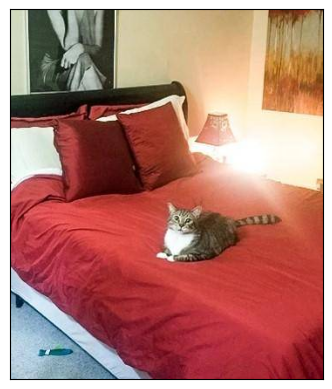

In [12]:
show_images_based_on_query("cat")

Response: ['resources/bedroom_1.jpg', 'resources/bedroom_2_cat.jpg']


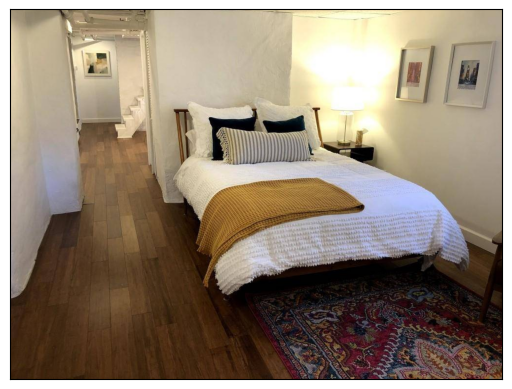

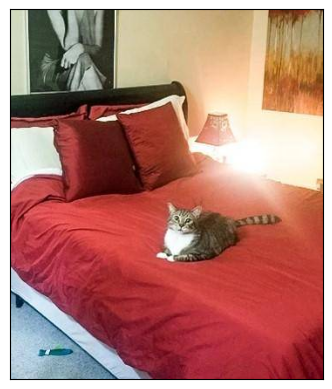

In [13]:
show_images_based_on_query("bedroom")

Response: ['resources/kitchen_4.jpg', 'resources/kitchen_4_messy.jpg', 'resources/kitchen_1_messy.jpg', 'resources/kitchen_2.jpg', 'resources/kitchen_1.jpg', 'resources/kitchen_3.jpg']


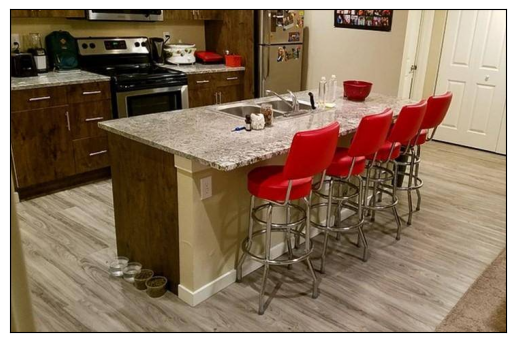

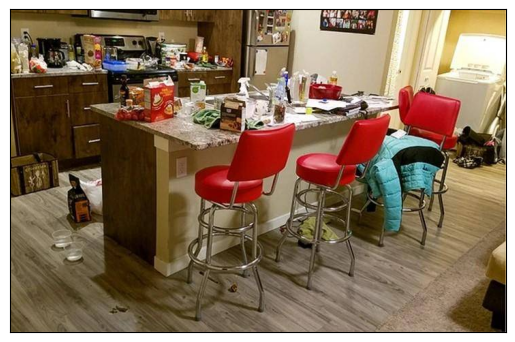

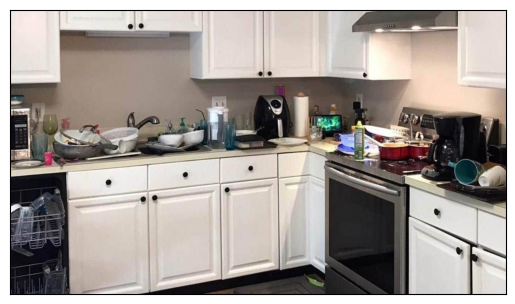

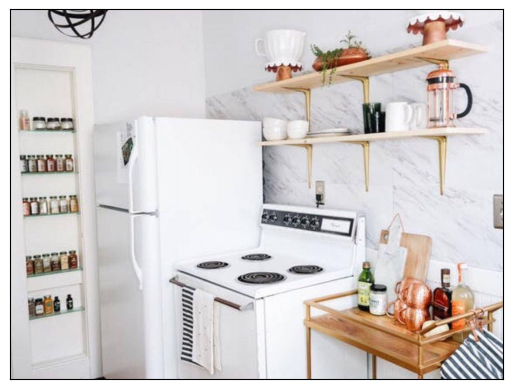

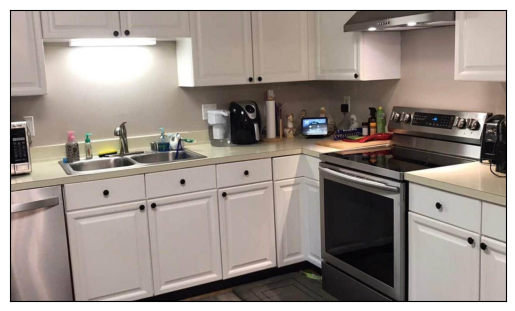

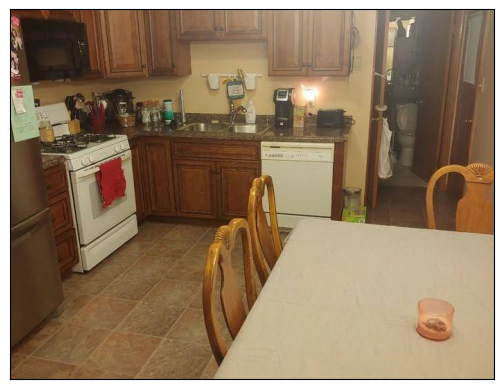

In [14]:
show_images_based_on_query("kitchen")

In [11]:
raise Exception("Stop here")

Exception: Stop here

In [15]:
delete_response = delete_images(image_filenames)
print("Response:", delete_response)

Response: <Response [200]>
